In [5]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
# Optional: for displaying images/videos directly in the notebook output
from IPython.display import display, Image, clear_output 
import time # To add slight delay in display loop if needed
import random # For generating random colors for tracks

# 1.Estimate Camera Parameters from the Video

In [3]:
# 1.1 Gather Video Frames
video_path = './input_videos/cars_rear_2.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file: {video_path}")
    frame_width, frame_height = None, None
else:
    # Get some basic video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video loaded: {video_path}")
    print(f"Resolution: {frame_width}x{frame_height}, FPS: {fps:.2f}, Total Frames: {frame_count}")

Video loaded: ./input_videos/cars_rear_2.mp4
Resolution: 960x720, FPS: 30.00, Total Frames: 558


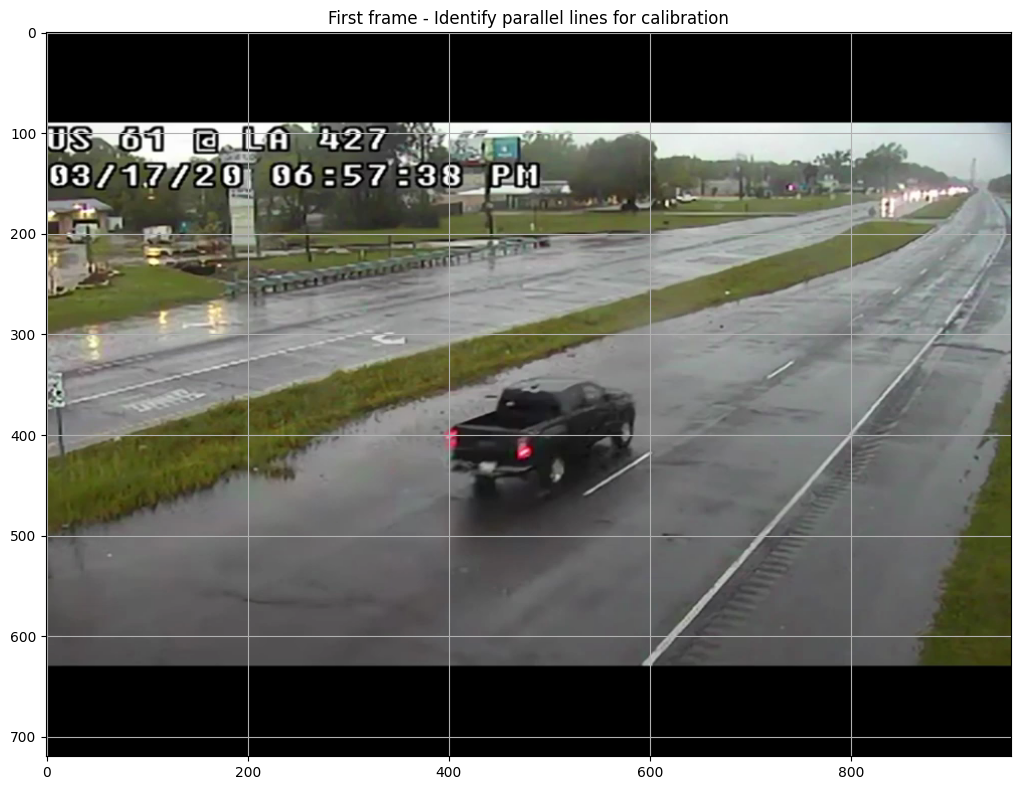

In [6]:
# Extract the first frame for parameter estimation
first_frame = None
if cap.isOpened():
    ret, first_frame = cap.read()
    if not ret:
        print("Failed to read frame from video")
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to beginning

# Display the first frame
if first_frame is not None:
    plt_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(plt_frame)
    plt.title("First frame - Identify parallel lines for calibration")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No frame available for parameter estimation")

In [7]:
# Function to find vanishing point from two sets of parallel lines
def find_vanishing_point(lines):
    """
    Find the vanishing point from parallel lines in the image
    Input: lines - list of lines, each defined by two points [(x1,y1,x2,y2), ...]
    Output: vanishing point coordinates (vp_x, vp_y)
    """
    if len(lines) < 2:
        print("Need at least two lines to find vanishing point")
        return None
    
    # Convert lines into mathematical form ax + by + c = 0
    line_params = []
    for x1, y1, x2, y2 in lines:
        # Handle vertical lines specially to avoid division by zero
        if x2 == x1:
            a, b, c = 1, 0, -x1
        else:
            a = (y2 - y1) / (x2 - x1)
            b = -1
            c = y1 - a * x1
        line_params.append((a, b, c))
    
    # Use all pairs of lines to find vanishing point candidates
    vp_candidates = []
    for i in range(len(line_params)):
        for j in range(i+1, len(line_params)):
            a1, b1, c1 = line_params[i]
            a2, b2, c2 = line_params[j]
            
            # Check if lines are parallel (no vanishing point)
            det = a1*b2 - a2*b1
            if abs(det) < 1e-10:  # Almost parallel
                continue
                
            # Solve for the intersection point (vanishing point)
            vp_x = (b1*c2 - b2*c1) / det
            vp_y = (a2*c1 - a1*c2) / det
            
            vp_candidates.append((vp_x, vp_y))
    
    if not vp_candidates:
        print("Could not find vanishing point from given lines")
        return None
    
    # Average the vanishing point candidates for a more robust estimate
    vp_x = np.mean([vp[0] for vp in vp_candidates])
    vp_y = np.mean([vp[1] for vp in vp_candidates])
    
    return (vp_x, vp_y)

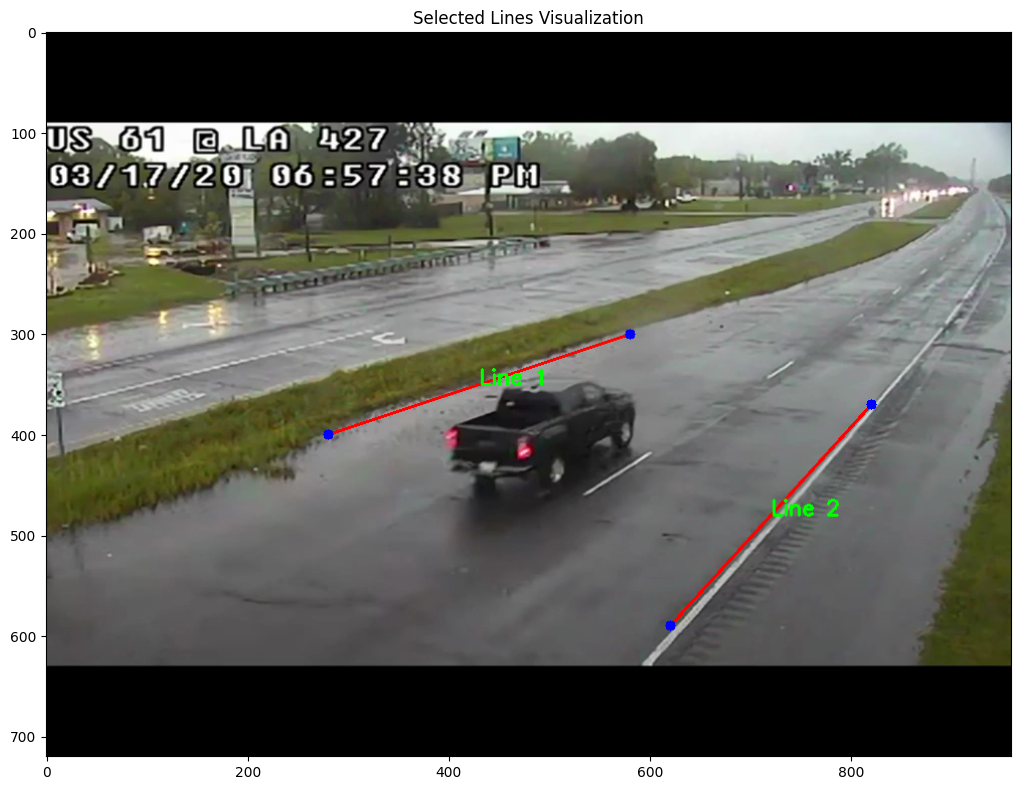

Defined lines: [(280, 400, 580, 300), (620, 590, 820, 370)]


In [26]:
# Manual line selection for calibration
def draw_lines_on_image(image, lines):
    """Draw lines on an image and display the result"""
    vis_img = image.copy()
    for i, (x1, y1, x2, y2) in enumerate(lines):
        cv2.line(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
        # Draw small circles at endpoints
        cv2.circle(vis_img, (int(x1), int(y1)), 5, (255, 0, 0), -1)
        cv2.circle(vis_img, (int(x2), int(y2)), 5, (255, 0, 0), -1)
        # Label the line
        cv2.putText(vis_img, f"Line {i+1}", ((int(x1) + int(x2))//2, (int(y1) + int(y2))//2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    plt_vis = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(plt_vis)
    plt.title("Selected Lines Visualization")
    plt.tight_layout()
    plt.show()
    
    return vis_img

# Instead of interactive selection, define the lines manually
# You can look at the displayed image and note the coordinates

# Define the road edge lines manually (these are example values - adjust based on your image)
# Format: [(x1, y1, x2, y2), (x3, y3, x4, y4)]
# You need to replace these with actual values from your image!
parallel_lines = [
    (280, 400, 580, 300),  # Left edge of the road (approximate x,y coordinates)
    (620, 590, 820, 370)   # Right edge of the road (approximate x,y coordinates)
]

# Visualize the manually defined lines to verify
if first_frame is not None:
    vis_img = draw_lines_on_image(first_frame, parallel_lines)
    print(f"Defined lines: {parallel_lines}")
else:
    print("No frame available for line visualization")

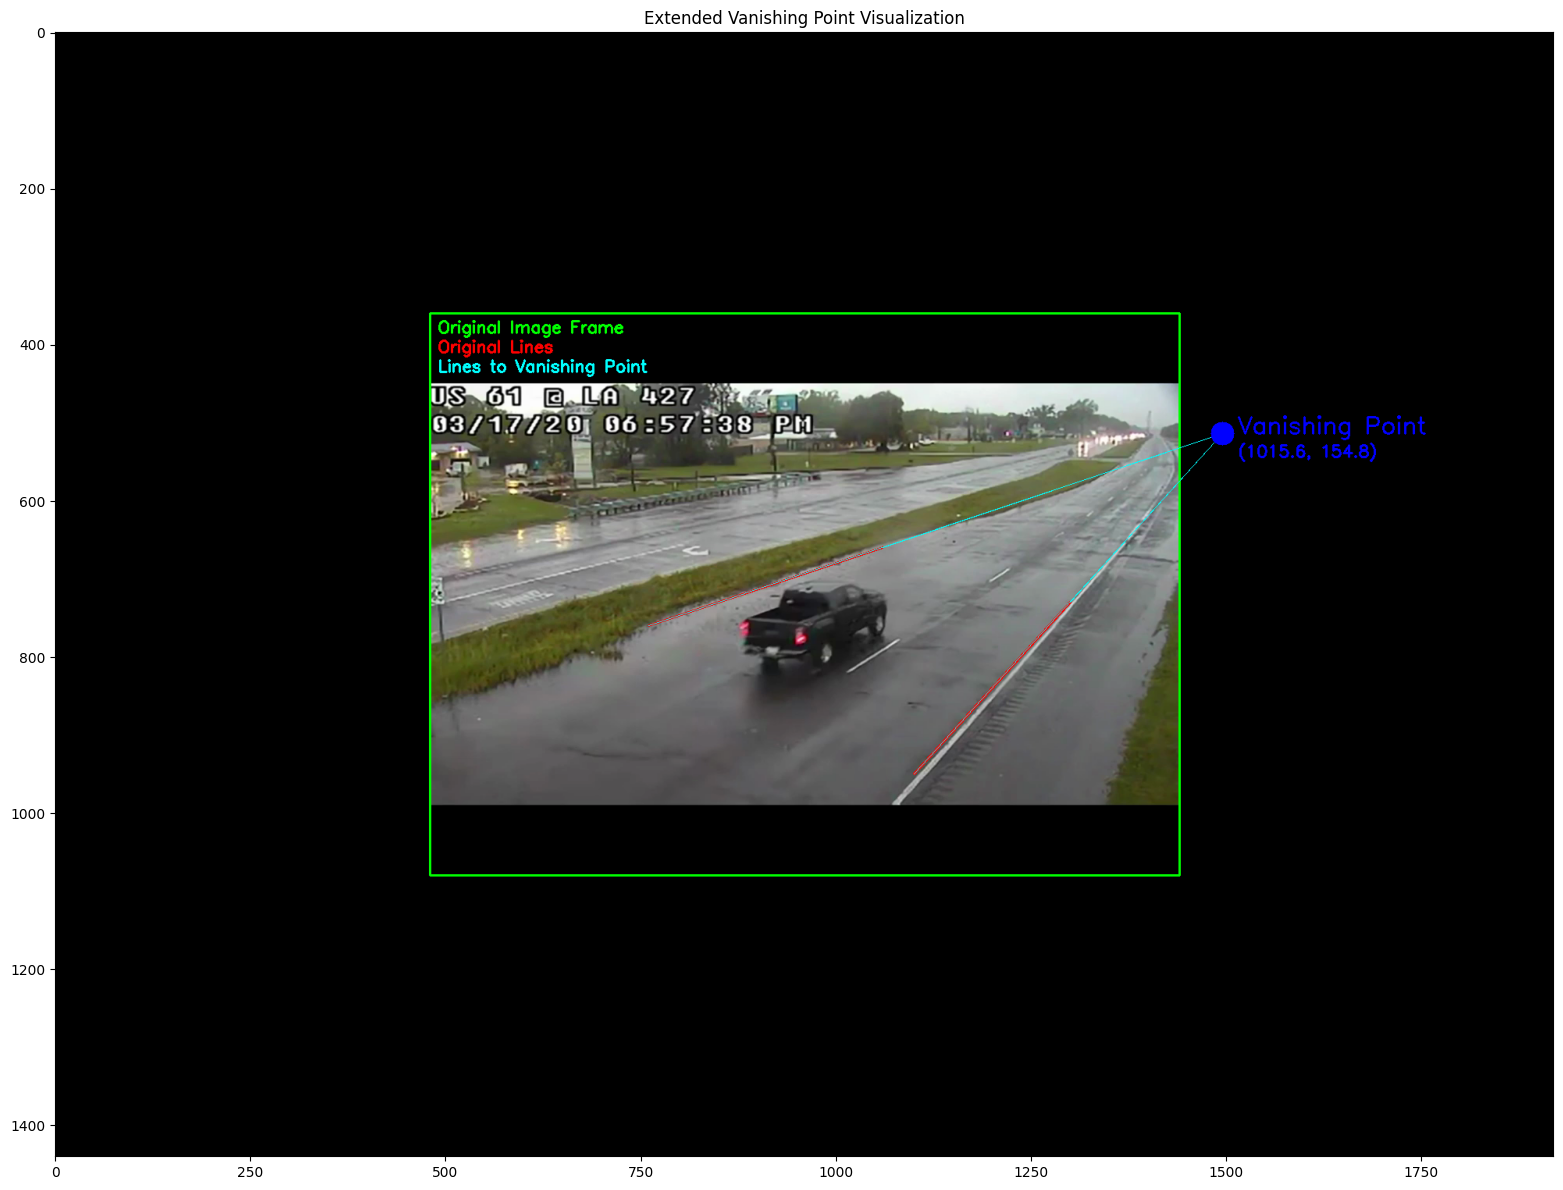

In [51]:
# Function to visualize the vanishing point (including extended canvas)
def visualize_vanishing_point_extended(frame, parallel_lines, vanishing_point, canvas_scale=5):
    """Visualize the vanishing point and line extensions on a larger canvas"""
    h, w = frame.shape[:2]
    vp_x, vp_y = vanishing_point
    
    # Create a larger canvas
    canvas_width = w * canvas_scale
    canvas_height = h * canvas_scale
    
    # Calculate offset to center the original image
    offset_x = (canvas_width - w) // 2
    offset_y = (canvas_height - h) // 2
    
    # Create canvas with the original image centered
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    canvas[offset_y:offset_y+h, offset_x:offset_x+w] = frame
    
    # Draw a border around the original image
    cv2.rectangle(canvas, (offset_x, offset_y), (offset_x+w, offset_y+h), (0, 255, 0), 2)
    
    # Adjust vanishing point coordinates
    canvas_vp_x = vp_x + offset_x
    canvas_vp_y = vp_y + offset_y
    
    # Draw the original lines
    for i, (x1, y1, x2, y2) in enumerate(parallel_lines):
        pt1 = (int(x1 + offset_x), int(y1 + offset_y))
        pt2 = (int(x2 + offset_x), int(y2 + offset_y))
        cv2.line(canvas, pt1, pt2, (0, 0, 255), 2)
        
        # Draw lines from points to vanishing point
        cv2.line(canvas, pt1, (int(canvas_vp_x), int(canvas_vp_y)), (255, 255, 0), 1)
        cv2.line(canvas, pt2, (int(canvas_vp_x), int(canvas_vp_y)), (255, 255, 0), 1)
    
    # Draw the vanishing point
    if 0 <= canvas_vp_x < canvas_width and 0 <= canvas_vp_y < canvas_height:
        cv2.circle(canvas, (int(canvas_vp_x), int(canvas_vp_y)), 15, (255, 0, 0), -1)
        cv2.putText(canvas, "Vanishing Point", (int(canvas_vp_x) + 20, int(canvas_vp_y)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)
        
        # Show coordinates
        coord_text = f"({vp_x:.1f}, {vp_y:.1f})"
        cv2.putText(canvas, coord_text, (int(canvas_vp_x) + 20, int(canvas_vp_y) + 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    # Add legend
    cv2.putText(canvas, "Original Image Frame", (offset_x + 10, offset_y + 25), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(canvas, "Original Lines", (offset_x + 10, offset_y + 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(canvas, "Lines to Vanishing Point", (offset_x + 10, offset_y + 75), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    
    # Display the visualization
    plt_canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 12))
    plt.imshow(plt_canvas)
    plt.title("Extended Vanishing Point Visualization")
    plt.tight_layout()
    plt.show()

# Visualize the vanishing point on an extended canvas
if 'vp' in locals() and vp and first_frame is not None:
    visualize_vanishing_point_extended(first_frame, parallel_lines, vp, canvas_scale=2)

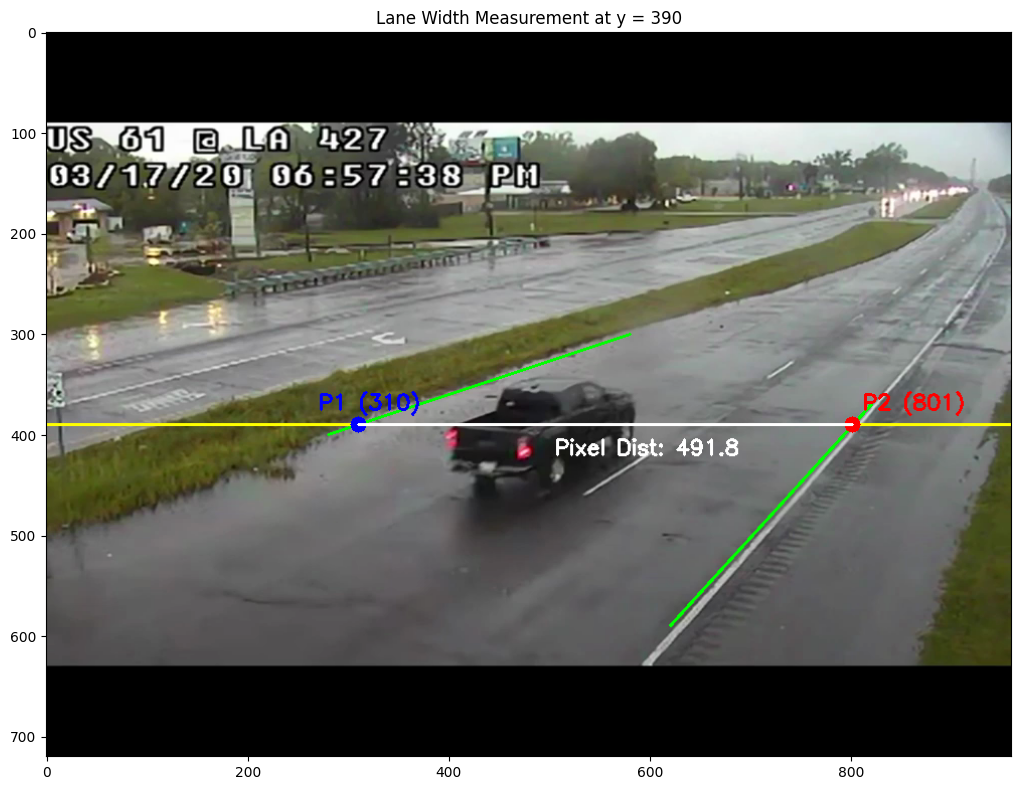


Measurement results:
Pixel distance: 491.82 pixels
Reference y: 390
Distance to vanishing point y: 235.22 pixels

Focal length from horizon method: 33052.99 pixels (not reliable)

Focal length estimates from typical field of view values:
FOV: 50° → focal length: 1029.4 pixels
FOV: 60° → focal length: 831.4 pixels
FOV: 70° → focal length: 685.5 pixels

Recommended focal length: 1029.4 pixels (based on 50° FOV)


In [52]:
# Measure pixel distance between parallel lines at a specific y-coordinate
def measure_lane_width(frame, parallel_lines, reference_y=None):
    """
    Calculate the pixel distance between parallel lines at a specific y-coordinate
    """
    h, w = frame.shape[:2]
    
    # Use default reference_y if not provided
    if reference_y is None:
        reference_y = h * 0.8
    reference_y = int(reference_y)
    
    # Extract line coordinates
    (x1, y1, x2, y2), (x3, y3, x4, y4) = parallel_lines
    
    # Calculate intersection with reference_y
    # First line
    if min(y1, y2) <= reference_y <= max(y1, y2):
        t = (reference_y - y1) / (y2 - y1) if y2 != y1 else 0
        x_at_ref_y1 = x1 + t * (x2 - x1)
        pt1 = (int(x_at_ref_y1), reference_y)
    else:
        print("Reference_y doesn't intersect with first line segment")
        return None
        
    # Second line
    if min(y3, y4) <= reference_y <= max(y3, y4):
        t = (reference_y - y3) / (y4 - y3) if y4 != y3 else 0
        x_at_ref_y2 = x3 + t * (x4 - x3)
        pt2 = (int(x_at_ref_y2), reference_y)
    else:
        print("Reference_y doesn't intersect with second line segment")
        return None
    
    # Calculate pixel distance
    pixel_distance = abs(x_at_ref_y2 - x_at_ref_y1)
    
    # Create visualization
    vis_img = frame.copy()
    
    # Draw the horizontal reference line
    cv2.line(vis_img, (0, reference_y), (w, reference_y), (0, 255, 255), 2)
    
    # Draw the original parallel lines
    cv2.line(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.line(vis_img, (int(x3), int(y3)), (int(x4), int(y4)), (0, 255, 0), 2)
    
    # Draw the intersection points
    cv2.circle(vis_img, pt1, 8, (255, 0, 0), -1)
    cv2.putText(vis_img, f"P1 ({pt1[0]})", (pt1[0] - 40, pt1[1] - 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                
    cv2.circle(vis_img, pt2, 8, (0, 0, 255), -1)
    cv2.putText(vis_img, f"P2 ({pt2[0]})", (pt2[0] + 10, pt2[1] - 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Draw the measured distance line
    cv2.line(vis_img, pt1, pt2, (255, 255, 255), 2)
    cv2.putText(vis_img, f"Pixel Dist: {pixel_distance:.1f}", 
                ((pt1[0] + pt2[0])//2 - 50, reference_y + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Display
    plt_vis = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(plt_vis)
    plt.title(f"Lane Width Measurement at y = {reference_y}")
    plt.tight_layout()
    plt.show()
    
    return {
        'reference_y': reference_y,
        'left_x': pt1[0],
        'right_x': pt2[0],
        'pixel_distance': pixel_distance
    }

# Calculate focal length using FOV approach
def calculate_focal_length_from_fov(image_width, fov_degrees):
    """Calculate focal length from field of view"""
    return (image_width / 2) / np.tan(np.radians(fov_degrees / 2))

# Measure lane width and calculate camera parameters
if 'vp' in locals() and vp and first_frame is not None:
    # Known parameters
    known_distance_meters = 3.5  # Lane width in meters
    
    # Find a suitable reference_y that intersects both line segments
    reference_y = 390  # This value worked well in previous tests
    
    # Measure lane width
    measurement = measure_lane_width(first_frame, parallel_lines, reference_y)
    
    if measurement:
        print(f"\nMeasurement results:")
        print(f"Pixel distance: {measurement['pixel_distance']:.2f} pixels")
        print(f"Reference y: {measurement['reference_y']}")
        
        # Calculate distance to vanishing point
        vp_x, vp_y = vp
        d_vp_y = abs(measurement['reference_y'] - vp_y)
        print(f"Distance to vanishing point y: {d_vp_y:.2f} pixels")
        
        # Calculate focal length using different methods
        # Method 1: Based on horizon line and lane width (prone to high values)
        focal_length_horizon = measurement['pixel_distance'] * d_vp_y / known_distance_meters
        print(f"\nFocal length from horizon method: {focal_length_horizon:.2f} pixels (not reliable)")
        
        # Method 2: Based on typical field of view for traffic cameras
        print("\nFocal length estimates from typical field of view values:")
        fov_options = [50, 60, 70]
        fov_results = []
        
        for fov in fov_options:
            f = calculate_focal_length_from_fov(first_frame.shape[1], fov)
            fov_results.append({'fov_degrees': fov, 'focal_length': f})
            print(f"FOV: {fov}° → focal length: {f:.1f} pixels")
        
        # Recommended focal length (using 50-degree FOV as typical for traffic cameras)
        recommended_focal_length = fov_results[0]['focal_length']
        print(f"\nRecommended focal length: {recommended_focal_length:.1f} pixels (based on 50° FOV)")

In [53]:
# Final camera parameters based on our calibration results
final_camera_parameters = {
    # Use the focal length from the FOV method (50 degrees)
    'focal_length_x': recommended_focal_length,  # From the FOV calculation in previous cell
    'focal_length_y': recommended_focal_length,  # Assuming square pixels
    'principal_point_x': first_frame.shape[1] / 2,  # Image center (width/2)
    'principal_point_y': first_frame.shape[0] / 2,  # Image center (height/2)
    'distortion_coeffs': np.zeros(5),  # Assuming no distortion
    'vanishing_point': vp,  # From the calculation in cell 4
    'camera_height_pixels': measurement['reference_y'] - vp[1],  # From our measurements
    'pixel_distance_at_reference': measurement['pixel_distance'],  # Lane width in pixels
    'reference_y': measurement['reference_y'],  # Where we measured the lane width
    'known_distance_meters': known_distance_meters,  # Real-world lane width
    'image_width': first_frame.shape[1],
    'image_height': first_frame.shape[0]
}

print("\nFinal Camera Parameters:")
for key, value in final_camera_parameters.items():
    print(f"{key}: {value}")

# Clean up
if 'cap' in locals() and cap is not None:
    cap.release()
print("Video capture released. Part 1 complete.")


Final Camera Parameters:
focal_length_x: 1029.363321844588
focal_length_y: 1029.363321844588
principal_point_x: 480.0
principal_point_y: 360.0
distortion_coeffs: [          0           0           0           0           0]
vanishing_point: (1015.65, 154.78)
camera_height_pixels: 235.22
pixel_distance_at_reference: 491.81818181818176
reference_y: 390
known_distance_meters: 3.5
image_width: 960
image_height: 720
Video capture released. Part 1 complete.
